In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pressure_level import get_reference_pressure

In [2]:
# ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.4x5.nc').isel(time=0)
ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.025x03125.nc').isel(time=0)
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lev: 72, lon: 1152)
Coordinates:
    time     datetime64[ns] 2016-07-01T01:30:00
  * lev      (lev) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.6875 -179.375 -179.0625 -178.75 ...
Data variables:
    DTRAIN   (lev, lat, lon) float32 ...
    OMEGA    (lev, lat, lon) float32 ...
    RH       (lev, lat, lon) float32 ...
    U        (lev, lat, lon) float32 ...
    V        (lev, lat, lon) float32 ...
Attributes:
    Title:                 GEOS-FP time-averaged 3-hour dynamical parameters ...
    Contact:               GEOS-Chem Support Team (geos-chem-support@as.harva...
    References:            www.geos-chem.org; wiki.geos-chem.org
    Filename:              GEOSFP.20160701.A3dyn.025x03125.nc
    History:               File generated on: 2017/07/20 19:45:16 GMT-0300
    ProductionDateTime:    File generated on: 2017

In [3]:
ps = xr.open_dataset('./GEOSFP.20160701.I3.025x03125.nc')['PS'].isel(time=[0, 1]).mean(dim='time')
# ps = xr.open_dataset('./GEOSFP.20160701.I3.4x5.nc')['PS'].isel(time=0)
ps

<xarray.DataArray 'PS' (lat: 721, lon: 1152)>
array([[ 677.834  ,  677.834  ,  677.834  , ...,  677.834  ,  677.834  ,
         677.834  ],
       [ 673.874  ,  673.894  ,  673.93396, ...,  673.79395,  673.81396,
         673.834  ],
       [ 667.31396,  667.354  ,  667.43396, ...,  667.114  ,  667.194  ,
         667.234  ],
       ...,
       [1007.53394, 1007.53394, 1007.53394, ..., 1007.53394, 1007.53394,
        1007.53394],
       [1007.53394, 1007.53394, 1007.53394, ..., 1007.53394, 1007.53394,
        1007.53394],
       [1007.37396, 1007.37396, 1007.37396, ..., 1007.37396, 1007.37396,
        1007.37396]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.6875 -179.375 -179.0625 -178.75 ...

In [4]:
p_edge = get_reference_pressure(ps)
p_edge.shape

# thickness of each layer
p_thick = p_edge[:-1] - p_edge[1:]
p_thick.shape

(72, 721, 1152)

In [5]:
p_edge_ref = get_reference_pressure()
p_thick_ref = p_edge_ref[:-1] - p_edge_ref[1:]
p_thick_ref.shape

(72,)

In [6]:
%%time

# compute pressure-weighted vertical average but uses reference pressure for normalization. Gives the smallest divergence.
u = np.sum(ds['U'].values*p_thick, axis=0) / np.sum(p_thick_ref)
v = np.sum(ds['V'].values*p_thick, axis=0) / np.sum(p_thick_ref)

# compute pressure-weighted vertical average. Not divergence-free near terrian.
# u = np.sum(ds['U'].values*p_thick, axis=0) / np.sum(p_thick, axis=0)
# v = np.sum(ds['V'].values*p_thick, axis=0) / np.sum(p_thick, axis=0)

# or compute unweighted average. Not divergence-free near terrian.
# u = np.mean(ds['U'].values, axis=0)
# v = np.mean(ds['V'].values, axis=0)

# or just get a single layer. Not divergence-free!
# u = ds['U'].isel(lev=20).values
# v = ds['V'].isel(lev=20).values

CPU times: user 4.52 s, sys: 1.27 s, total: 5.79 s
Wall time: 5.18 s


In [7]:
u.shape, v.shape

((721, 1152), (721, 1152))

In [8]:
# grid size for computing spatial derivative

# 4x5 resolution
# dlat, dlon = 4.0, 5.0
# lat = np.clip(ds['lat'].values, -88, 88)

# 0.25x0.3125 resolution
dlat, dlon = 0.25, 0.3125
lat = ds['lat'].values

dy = 110.574e3 * dlat  # m / degree lat
dx = 111.320e3 * np.cos(lat/180*np.pi) * dlon # m / degree lon

dx.shape, dy

((721,), 27643.5)

In [9]:
# spatial derivative
# axis number assumes 2D array
dudx = (np.roll(u,-1,axis=1)-np.roll(u,1,axis=1))/(2*dx[:,np.newaxis])
dvdy = (np.roll(v,-1,axis=0)-np.roll(v,1,axis=0))/(2*dy)
div = dudx + dvdy

In [10]:
# for making new data array
coords = {'lat': ds['lat'], 'lon': ds['lon']}

Text(0.5,1,'divergence (1/s)')

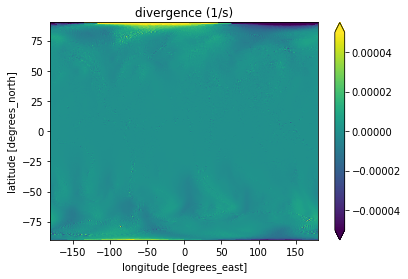

In [11]:
xr.DataArray(div, dims=['lat', 'lon'], coords=coords).plot(vmin=-5e-5, vmax=5e-5)
plt.title('divergence (1/s)')

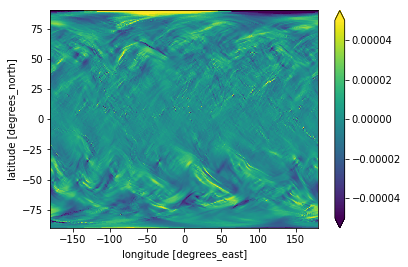

In [12]:
xr.DataArray(dudx, dims=['lat', 'lon'], coords=coords).plot(vmin=-5e-5, vmax=5e-5)

Text(0.5,1,'|div| / (|du/dx|+|dv/dy|)')

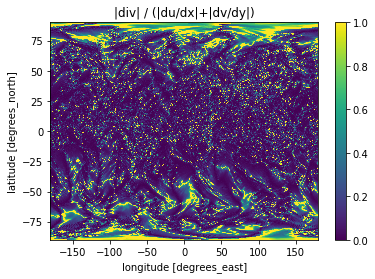

In [13]:
# Almost divergence freeBecause surface pressure is not accurate is enough?
xr.DataArray(np.abs(div)/(np.abs(dudx)+np.abs(dvdy)), dims=['lat', 'lon'], coords=coords).plot(vmin=0, vmax=1)
plt.title('|div| / (|du/dx|+|dv/dy|)')